1. Import necessary libraries and loading the dataset

In [ ]:
import pandas as pd

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score,recall_score,f1_score,classification_report
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


file_path = '/content/drive/MyDrive/ImageProcessing/Dataset3_Apr/GPS_Data_Simplified_2D_Feature_Map.csv'
data = pd.read_csv(file_path)

# Check the dataset structure
data.head()


PRN           DO             PD         RX            TOW            CP  \
0    6  1160.671408 -238359.543282  491568.00  491568.000795 -24660.263293   
1    6  1157.827808 -238363.921192  491568.02  491568.020795 -24683.468520   
2    6  1161.135932 -238368.638615  491568.04  491568.040795 -24706.687357   
3    6  1161.156617 -238373.391775  491568.06  491568.060795 -24729.920039   
4    6  1160.690893 -238378.127066  491568.08  491568.080795 -24753.153999   

          EC         LC         PC        PIP          PQP        TCD  \
0  163521.78  170008.81  179294.97  178420.33 -17688.17800  1158.4806   
1  158277.05  160253.09  182106.11  182106.05    158.33333  1160.7948   
2  184442.36  193125.89  208228.02 -205198.30  35391.59000  1157.6909   
3  159812.45  169960.55  187550.72  187543.00  -1701.94400  1161.1343   
4  183557.66  191912.58  208403.50  208330.05  -5532.89990  1161.1759   

         CN0  Output  
0  49.412529       0  
1  49.452686       0  
2  49.480145       0  
3  49.433769       0  
4  49.391670       0

2. Counting the label values as target values

In [ ]:
print("Any nulls in the given data frame ",data.isnull().values.any() )
#print('-------')
print("No. of unique labels ",len(data['Output'].unique()))
print("Label values ",data.Output.unique())#0 is for normal
#1 is for simpistic attack,2 for intermediate spoofing attack, 3 is for sophisticated spoofing attack
print('-------')
print("Break down of the Normal and Spoofed")
print(pd.value_counts(data['Output'], sort = True) )

Any nulls in the given data frame  False
No. of unique labels  4
Label values  [0 1 2 3]
-------
Break down of the Normal and Spoofed
Output
0    397825
2     44232
1     36458
3     32015
Name: count, dtype: int64


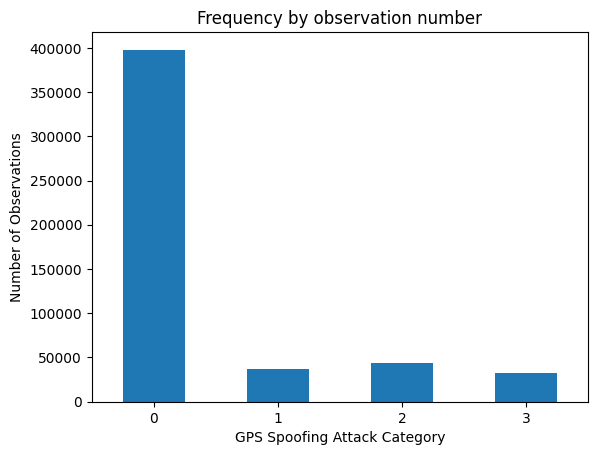

In [ ]:
count_type = pd.value_counts(data['Output'], sort = False)
count_type.plot(kind = 'bar', rot=0)
plt.xticks(range(len(data['Output'].unique())), data.Output.unique())
plt.title("Frequency by observation number")
plt.xlabel("GPS Spoofing Attack Category")
plt.ylabel("Number of Observations");

3. Splitting the data into training data as 80%,testing data-20% and out of training data ,splitting it to training as 70% and validation data as 30%

In [ ]:
from sklearn.model_selection import train_test_split

# Separate features and target
X = data.drop('Output', axis=1)
y = data['Output']

# Split the dataset (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the train set into train and validation sets (70% train, 30% validation)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)


Scaling

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)
print (X_test_scaled)

[[0.82758621 0.24214016 0.90742379 ... 0.54087308 0.1916612  0.9736342 ]
 [0.17241379 0.72263898 0.30553467 ... 0.47009124 0.81001086 0.92225747]
 [0.62068966 0.58361162 0.36244855 ... 0.42622139 0.63192249 0.79543066]
 ...
 [0.82758621 0.23744377 0.90684464 ... 0.4969587  0.19638406 0.94102279]
 [0.48275862 0.30898668 0.26445147 ... 0.56744463 0.27378491 0.91016137]
 [0.06896552 0.52198075 0.26441546 ... 0.50494616 0.33864574 0.8604945 ]]


In [ ]:
print (X_val_scaled)

[[0.86206897 0.80414854 0.09768202 ... 0.53001775 0.90686271 0.88992542]
 [0.24137931 0.56856947 0.2606669  ... 0.51465813 0.61002891 0.90918236]
 [0.24137931 0.5373003  0.25346763 ... 0.56030363 0.56936409 0.91154261]
 ...
 [0.         0.6303193  0.21236756 ... 0.47159195 0.69079688 0.91500965]
 [0.86206897 0.79294828 0.94868324 ... 0.52224515 0.90840369 0.86897425]
 [0.24137931 0.54682238 0.25668689 ... 0.50042823 0.58613014 0.93196611]]


In [ ]:
print (X_test_scaled)

[[0.82758621 0.24214016 0.90742379 ... 0.54087308 0.1916612  0.9736342 ]
 [0.17241379 0.72263898 0.30553467 ... 0.47009124 0.81001086 0.92225747]
 [0.62068966 0.58361162 0.36244855 ... 0.42622139 0.63192249 0.79543066]
 ...
 [0.82758621 0.23744377 0.90684464 ... 0.4969587  0.19638406 0.94102279]
 [0.48275862 0.30898668 0.26445147 ... 0.56744463 0.27378491 0.91016137]
 [0.06896552 0.52198075 0.26441546 ... 0.50494616 0.33864574 0.8604945 ]]


4. Creating the autoencoder model

In [ ]:
# Function to create an autoencoder
def create_autoencoder(input_dim, encoding_dim):
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(encoding_dim, activation='relu')(input_layer)
    decoded = Dense(input_dim, activation='linear')(encoded)
    autoencoder = Model(input_layer, decoded)
    autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return autoencoder


In [ ]:
# Create and train the first autoencoder (13 -> 10)
autoencoder_13_to_10 = create_autoencoder(13, 10)
autoencoder_13_to_10.fit(X_train, X_train, epochs=50, batch_size=256, validation_data=(X_val, X_val))

Epoch 1/50
1117/1117 [==============================] - 4s 3ms/step - loss: 1588566032384.0000 - val_loss: 2654963456.0000
Epoch 2/50
1117/1117 [==============================] - 5s 4ms/step - loss: 1818113152.0000 - val_loss: 1448317312.0000
Epoch 3/50
1117/1117 [==============================] - 3s 3ms/step - loss: 1259438208.0000 - val_loss: 1095510912.0000
Epoch 4/50
1117/1117 [==============================] - 3s 2ms/step - loss: 954734464.0000 - val_loss: 821444672.0000
Epoch 5/50
1117/1117 [==============================] - 4s 3ms/step - loss: 729097216.0000 - val_loss: 653632384.0000
Epoch 6/50
1117/1117 [==============================] - 4s 3ms/step - loss: 571979264.0000 - val_loss: 512886016.0000
Epoch 7/50
1117/1117 [==============================] - 3s 2ms/step - loss: 472818528.0000 - val_loss: 443997280.0000
Epoch 8/50
1117/1117 [==============================] - 3s 2ms/step - loss: 421660160.0000 - val_loss: 407091968.0000
Epoch 9/50
1117/1117 [=========================

In [ ]:
#loss

In [ ]:
#classification
from sklearn.ensemble import RandomForestClassifier
classifier_13 = RandomForestClassifier(random_state=42)
classifier_13.fit(X_train, y_train)
predictions_13 = classifier_13.predict(X_test)


In [ ]:
#Calculate accuracy and confusion matrix
accuracy_13 = accuracy_score(y_test, predictions_13)
precision_13 = precision_score(y_test, predictions_13, average= 'weighted', zero_division=0)
recall_13 = recall_score(y_test, predictions_13,average= 'weighted', zero_division=0)
f1_13 = f1_score(y_test, predictions_13,average= 'weighted', zero_division=0)
confusion_13 = confusion_matrix(y_test, predictions_13)

In [ ]:
# Print out accuracy and confusion matrix
print(f'Accuracy for 13-dimensional data: {accuracy_13}')
print(f'Confusion Matrix for 13-dimensional data:\n{confusion_13}')
print(f'Precision for 13-dimensional data: {precision_13}')
print(f'Recall for 13-dimensional data: {recall_13}')
print(f'F1-score for 13-dimensional data: {f1_13}')


Accuracy for 13-dimensional data: 0.9114939376726148
Confusion Matrix for 13-dimensional data:
[[75893   791  2270   398]
 [  941  5592   852     0]
 [ 2494   794  5576     0]
 [  497     0     0  6008]]
Precision for 13-dimensional data: 0.910628460618694
Recall for 13-dimensional data: 0.9114939376726148
F1-score for 13-dimensional data: 0.9110349077184704


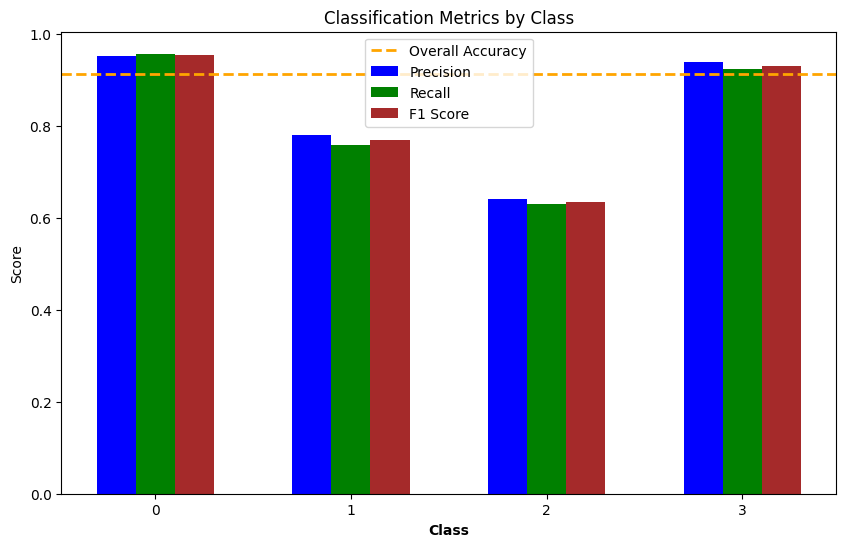

In [ ]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np

# Let's assume 'predictions' and 'y_test' are the predicted and actual labels respectively
report = classification_report(y_test, predictions_13, output_dict=True)

# Extracting the values for each class
classes = ['0', '1', '2', '3']
precision_13 = [report[cls]['precision'] for cls in classes]
recall_13 = [report[cls]['recall'] for cls in classes]
f1_score_13= [report[cls]['f1-score'] for cls in classes]
accuracy_13 = report['accuracy']  # Overall accuracy

# Prepare the bar chart for each metric by class
bar_width = 0.2
r1 = np.arange(len(precision_13))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Plotting each metric
plt.figure(figsize=(10, 6))
plt.bar(r1, precision_13, width=bar_width, color='blue', label='Precision')
plt.bar(r2, recall_13, width=bar_width, color='green', label='Recall')
plt.bar(r3, f1_13, width=bar_width, color='brown', label='F1 Score')

# Adding the overall accuracy line
plt.axhline(y=accuracy_13, label='Overall Accuracy', color='orange', linestyle='--', linewidth=2)

# Adding labels and title
plt.xlabel('Class', fontweight='bold')
plt.xticks([r + bar_width for r in range(len(f1_13))], classes)
plt.ylabel('Score')
plt.title('Classification Metrics by Class')

# Create legend & Show graphic
plt.legend()
plt.show()


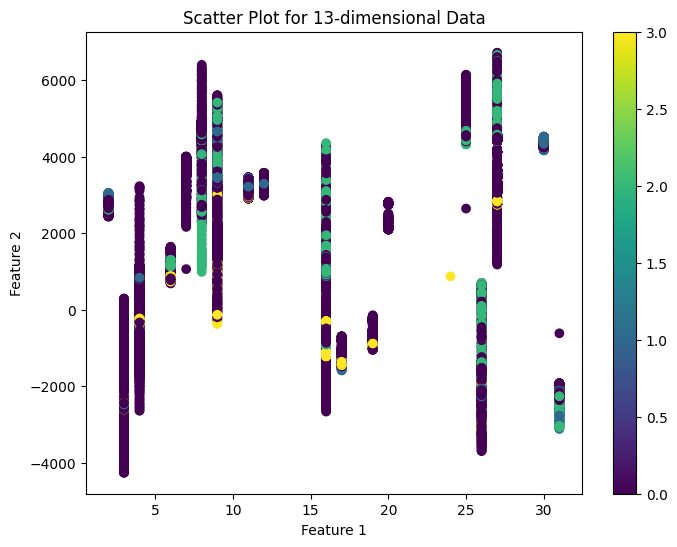

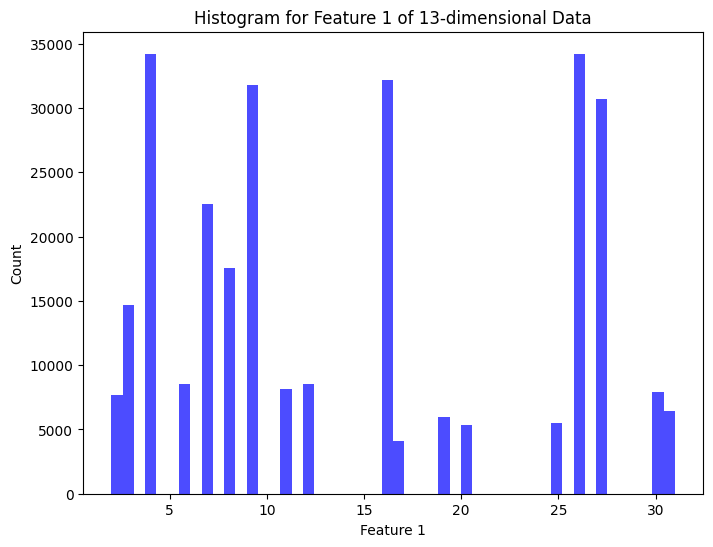

In [ ]:
# Plotting graphs
# Scatter plot for 13-dimensional data
plt.figure(figsize=(8, 6))
plt.scatter(X_train.iloc[:, 0], X_train.iloc[:, 1], c=y_train, cmap='viridis')  # Using iloc for integer-location based indexing
plt.title('Scatter Plot for 13-dimensional Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar()
plt.show()


# Histogram for the first feature in 13-dimensional data
plt.figure(figsize=(8, 6))
plt.hist(X_train.iloc[:, 0], bins=50, color='blue', alpha=0.7)  # Using iloc here as well
plt.title('Histogram for Feature 1 of 13-dimensional Data')
plt.xlabel('Feature 1')
plt.ylabel('Count')
plt.show()


In [ ]:
# Encode the data to 10 dimensions
encoder_10 = Model(autoencoder_13_to_10.input, autoencoder_13_to_10.layers[-2].output)
X_train_10 = encoder_10.predict(X_train)
X_test_10 = encoder_10.predict(X_test)

3191/3191 [==============================] - 4s 1ms/step


In [ ]:
# Train a classifier on the 10-dimensional data
import numpy as np
classifier_10 = RandomForestClassifier(n_estimators=100, random_state=42)
classifier_10.fit(X_train_10, y_train)
importances = classifier_10.feature_importances_
indices = np.argsort(importances)[::-1]
top_feature_indices = indices[:10]

#for finding top categories we add above predictions
predictions_10 = classifier_10.predict(X_test_10)

In [ ]:
# Create a dataset with only the top features
classifier_10_top_features = X_train_10[:, top_feature_indices]

In [ ]:
# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(classifier_10_top_features, y_train, test_size=0.2, random_state=42)

# Train a new RandomForest model on the selected top features
classifier_10_top_features = RandomForestClassifier(n_estimators=100, random_state=42)
classifier_10_top_features.fit(X_train, y_train)

# Predict and evaluate the model
predictions = classifier_10_top_features.predict(X_test)
print(classification_report(y_test, predictions))


              precision    recall  f1-score   support

           0       0.94      0.95      0.95     44603
           1       0.72      0.71      0.72      4036
           2       0.61      0.58      0.60      4916
           3       0.92      0.87      0.90      3625

    accuracy                           0.90     57180
   macro avg       0.80      0.78      0.79     57180
weighted avg       0.90      0.90      0.90     57180



Try for 13-8 using importance for top

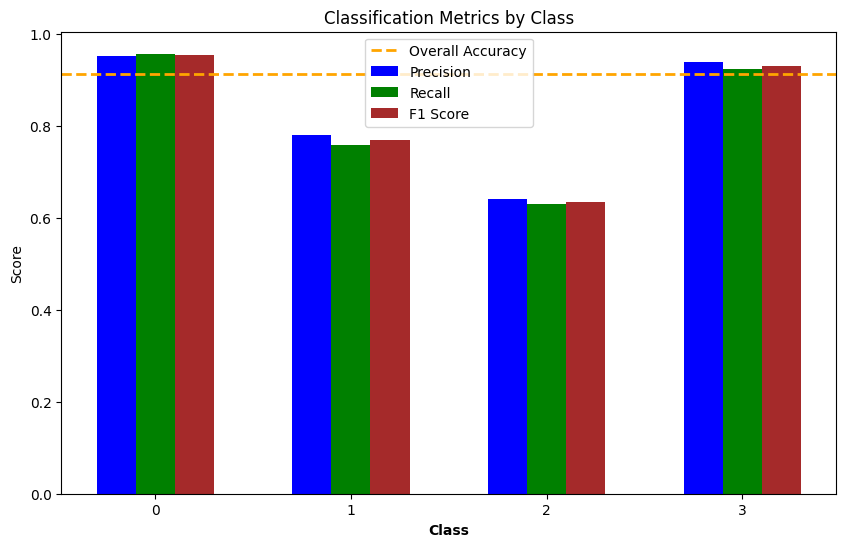

In [ ]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np

# Let's assume 'predictions' and 'y_test' are the predicted and actual labels respectively
report = classification_report(y_test, predictions_13, output_dict=True)

# Extracting the values for each class
classes = ['0', '1', '2', '3']
precision_10 = [report[cls]['precision'] for cls in classes]
recall_10 = [report[cls]['recall'] for cls in classes]
f1_score_10= [report[cls]['f1-score'] for cls in classes]
accuracy = report['accuracy']  # Overall accuracy

# Prepare the bar chart for each metric by class
bar_width = 0.2
r1 = np.arange(len(precision_13))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Plotting each metric
plt.figure(figsize=(10, 6))
plt.bar(r1, precision_10, width=bar_width, color='blue', label='Precision')
plt.bar(r2, recall_10, width=bar_width, color='green', label='Recall')
plt.bar(r3, f1_score_10, width=bar_width, color='brown', label='F1 Score')

# Adding the overall accuracy line
plt.axhline(y=accuracy, label='Overall Accuracy', color='orange', linestyle='--', linewidth=2)

# Adding labels and title
plt.xlabel('Class', fontweight='bold')
plt.xticks([r + bar_width for r in range(len(f1_13))], classes)
plt.ylabel('Score')
plt.title('Classification Metrics by Class')

# Create legend & Show graphic
plt.legend()
plt.show()


In [ ]:
autoencoder_13_to_8 = create_autoencoder(13, 8)
autoencoder_13_to_8.fit(X_train, X_train, epochs=50, batch_size=256, validation_data=(X_val, X_val))

# Encode the data to 10 dimensions
encoder_8 = Model(autoencoder_13_to_8.input, autoencoder_13_to_8.layers[-2].output)
X_train_8 = encoder_8.predict(X_train)
X_test_8 = encoder_8.predict(X_test)
# Train a classifier on the 8-dimensional data
import numpy as np
from sklearn.ensemble import RandomForestClassifier
classifier_8 = RandomForestClassifier(n_estimators=100, random_state=42)
classifier_8.fit(X_train_8, y_train)
importances = classifier_8.feature_importances_
indices = np.argsort(importances)[::-1]
top_feature_indices = indices[:8]

Epoch 1/50


ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model_3" is incompatible with the layer: expected shape=(None, 13), found shape=(None, 8)


In [ ]:

#for finding top categories we add above predictions
predictions_8 = classifier_8.predict(X_test_8)

In [ ]:
# Create a dataset with only the top features
classifier_8_top_features = X_train_8[:, top_feature_indices]

In [ ]:
# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(classifier_8_top_features, y_train, test_size=0.2, random_state=42)

# Train a new RandomForest model on the selected top features
classifier_8_top_features = RandomForestClassifier(n_estimators=100, random_state=42)
classifier_8_top_features.fit(X_train, y_train)

# Predict and evaluate the model
predictions = classifier_8_top_features.predict(X_test)
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))

TypeError: Expected sequence or array-like, got <class 'sklearn.ensemble._forest.RandomForestClassifier'>

In [ ]:
# Calculate accuracy and confusion matrix
precision_10 = precision_score(y_test, predictions_10, average= 'weighted', zero_division=0)
recall_10 = recall_score(y_test, predictions_10,average= 'weighted', zero_division=0)
f1_10 = f1_score(y_test, predictions_10,average= 'weighted', zero_division=0)
accuracy_10 = accuracy_score(y_test, predictions_10)
confusion_10 = confusion_matrix(y_test, predictions_10)


# Print out accuracy and confusion matrix
print(f'Accuracy for 10-dimensional data: {accuracy_10}')
print(f'Confusion Matrix for 10-dimensional data:\n{confusion_10}')
print(f'Precision for 10-dimensional data: {precision_10}')
print(f'Recall for 10-dimensional data: {recall_10}')
print(f'F1-score for 10-dimensional data: {f1_10}')


Accuracy for 10-dimensional data: 0.8903296574148434
Confusion Matrix for 10-dimensional data:
[[75412  1027  2332   581]
 [ 1174  5043  1159     9]
 [ 2825  1146  4893     0]
 [  928    17     0  5560]]
Precision for 10-dimensional data: 0.8881807596512412
Recall for 10-dimensional data: 0.8903296574148434
F1-score for 10-dimensional data: 0.8891395088758912


In [ ]:
# Create and train the second autoencoder (10 -> 8)
autoencoder_13_to_8 = create_autoencoder(13, 8)
autoencoder_13_to_8.fit(X_train, X_train, epochs=50, batch_size=256, validation_data=(X_test, X_test))

# Encode the data to 8 dimensions
encoder_8 = Model(autoencoder_13_to_8.input, autoencoder_13_to_8.layers[-2].output)
X_train_8 = encoder_8.predict(X_train)
X_test_8 = encoder_8.predict(X_test)

# Train a classifier on the 8-dimensional data
classifier_8 = RandomForestClassifier(random_state=42)
classifier_8.fit(X_train_8, y_train)
predictions_8 = classifier_8.predict(X_test_8)



# Calculate accuracy and confusion matrix
accuracy_8 = accuracy_score(y_test, predictions_8)
confusion_8 = confusion_matrix(y_test, predictions_8)
precision_8 = precision_score(y_test, predictions_8, average= 'weighted', zero_division=0)
recall_8 = recall_score(y_test, predictions_8,average= 'weighted', zero_division=0)
f1_8 = f1_score(y_test, predictions_8,average= 'weighted', zero_division=0)


Epoch 1/50
1117/1117 [==============================] - 12s 8ms/step - loss: 2285117112320.0000 - val_loss: 28536256512.0000
Epoch 2/50
1117/1117 [==============================] - 6s 6ms/step - loss: 21358970880.0000 - val_loss: 16173107200.0000
Epoch 3/50
1117/1117 [==============================] - 3s 3ms/step - loss: 6438882816.0000 - val_loss: 1912736256.0000
Epoch 4/50
1117/1117 [==============================] - 2s 2ms/step - loss: 1690043392.0000 - val_loss: 1596362368.0000
Epoch 5/50
1117/1117 [==============================] - 2s 2ms/step - loss: 1520403968.0000 - val_loss: 1463942016.0000
Epoch 6/50
1117/1117 [==============================] - 2s 2ms/step - loss: 873194880.0000 - val_loss: 482958304.0000
Epoch 7/50
1117/1117 [==============================] - 3s 3ms/step - loss: 458295488.0000 - val_loss: 446263072.0000
Epoch 8/50
1117/1117 [==============================] - 3s 2ms/step - loss: 409868576.0000 - val_loss: 371277088.0000
Epoch 9/50
1117/1117 [=================

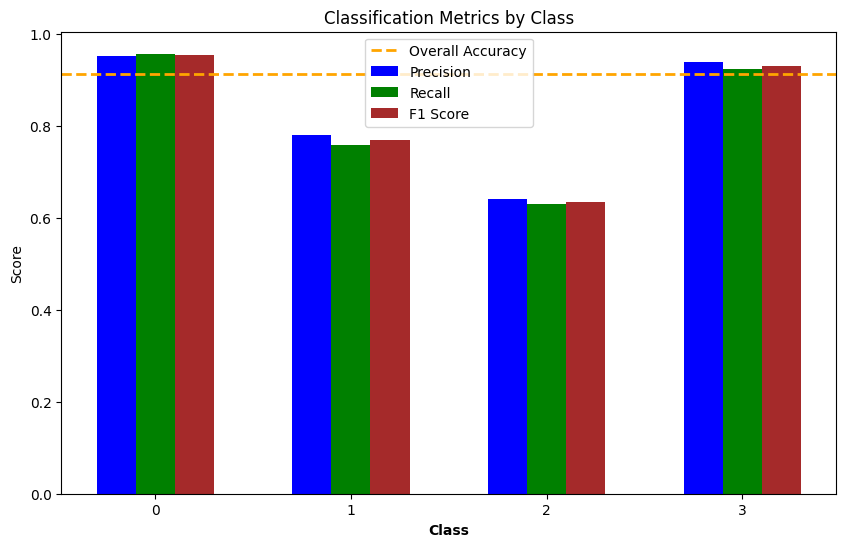

In [ ]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np

# Let's assume 'predictions' and 'y_test' are the predicted and actual labels respectively
report = classification_report(y_test, predictions_13, output_dict=True)

# Extracting the values for each class
classes = ['0', '1', '2', '3']
precision_8 = [report[cls]['precision'] for cls in classes]
recall_8 = [report[cls]['recall'] for cls in classes]
f1_score_8= [report[cls]['f1-score'] for cls in classes]
accuracy = report['accuracy']  # Overall accuracy

# Prepare the bar chart for each metric by class
bar_width = 0.2
r1 = np.arange(len(precision_13))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Plotting each metric
plt.figure(figsize=(10, 6))
plt.bar(r1, precision_8, width=bar_width, color='blue', label='Precision')
plt.bar(r2, recall_8, width=bar_width, color='green', label='Recall')
plt.bar(r3, f1_score_8, width=bar_width, color='brown', label='F1 Score')

# Adding the overall accuracy line
plt.axhline(y=accuracy, label='Overall Accuracy', color='orange', linestyle='--', linewidth=2)

# Adding labels and title
plt.xlabel('Class', fontweight='bold')
plt.xticks([r + bar_width for r in range(len(f1_13))], classes)
plt.ylabel('Score')
plt.title('Classification Metrics by Class')

# Create legend & Show graphic
plt.legend()
plt.show()

In [ ]:
'''
importances = classifier_8.feature_importances_

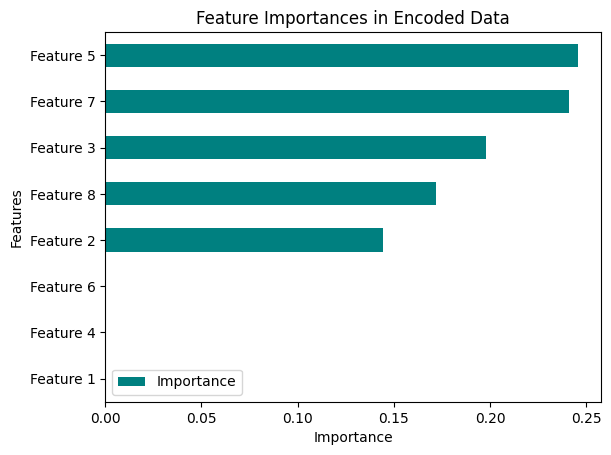

In [ ]:
'''
import pandas as pd
import matplotlib.pyplot as plt

# Create a DataFrame for visualization
feature_names = [f'Feature {i+1}' for i in range(X_train_8.shape[1])]
feature_importances = pd.DataFrame(importances, index=feature_names, columns=['Importance'])

# Plot feature importances
feature_importances.sort_values(by='Importance', ascending=True).plot(kind='barh', color='teal')
plt.title('Feature Importances in Encoded Data')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

In [ ]:
# Print out accuracy and confusion matrix
print(f'Accuracy for 8-dimensional data: {accuracy_8}')
print(f'Confusion Matrix for 8-dimensional data:\n{confusion_8}')
print(f'Precision for 8-dimensional data: {precision_8}')
print(f'Recall for 8-dimensional data: {recall_8}')
print(f'F1-score for 8-dimensional data: {f1_8}')


Accuracy for 8-dimensional data: 0.896538890956457
Confusion Matrix for 8-dimensional data:
[[75463  1050  2367   472]
 [ 1133  5111  1132     9]
 [ 2577  1144  5143     0]
 [  671     9     0  5825]]
Precision for 8-dimensional data: 0.8955648764629522
Recall for 8-dimensional data: 0.896538890956457
F1-score for 8-dimensional data: 0.896021486087863


In [ ]:
#For 5D
# Create and train the first autoencoder (13 -> 5)
autoencoder_13_to_5 = create_autoencoder(13, 5)
autoencoder_13_to_5.fit(X_train, X_train, epochs=50, batch_size=256, validation_data=(X_test, X_test))

# Encode the data to 5 dimensions
encoder_5 = Model(autoencoder_13_to_5.input, autoencoder_13_to_5.layers[-2].output)
X_train_5 = encoder_5.predict(X_train)
X_test_5 = encoder_5.predict(X_test)

# Train a classifier on the 5-dimensional data
classifier_5 = RandomForestClassifier(n_estimators=100, random_state=42)
classifier_5.fit(X_train_5, y_train)
predictions_5 = classifier_5.predict(X_test_5)

# Calculate accuracy and confusion matrix,precision,recall,F1-score
accuracy_5 = accuracy_score(y_test, predictions_5)
confusion_5 = confusion_matrix(y_test, predictions_5)

precision_5 = precision_score(y_test, predictions_5, average= 'weighted', zero_division=0)
recall_5 = recall_score(y_test, predictions_5,average= 'weighted', zero_division=0)
f1_5 = f1_score(y_test, predictions_5,average= 'weighted', zero_division=0)


Epoch 1/50
1117/1117 [==============================] - 5s 3ms/step - loss: 2547871383552.0000 - val_loss: 24795734016.0000
Epoch 2/50
1117/1117 [==============================] - 4s 4ms/step - loss: 18369406976.0000 - val_loss: 14587307008.0000
Epoch 3/50
1117/1117 [==============================] - 3s 3ms/step - loss: 12753128448.0000 - val_loss: 11357278208.0000
Epoch 4/50
1117/1117 [==============================] - 3s 2ms/step - loss: 10372194304.0000 - val_loss: 9506259968.0000
Epoch 5/50
1117/1117 [==============================] - 3s 2ms/step - loss: 8696154112.0000 - val_loss: 7873563648.0000
Epoch 6/50
1117/1117 [==============================] - 4s 4ms/step - loss: 7021238272.0000 - val_loss: 6209381888.0000
Epoch 7/50
1117/1117 [==============================] - 3s 3ms/step - loss: 5640409600.0000 - val_loss: 5169904640.0000
Epoch 8/50
1117/1117 [==============================] - 3s 2ms/step - loss: 4948745728.0000 - val_loss: 4802736128.0000
Epoch 9/50
1117/1117 [=========

0.9000058762462539


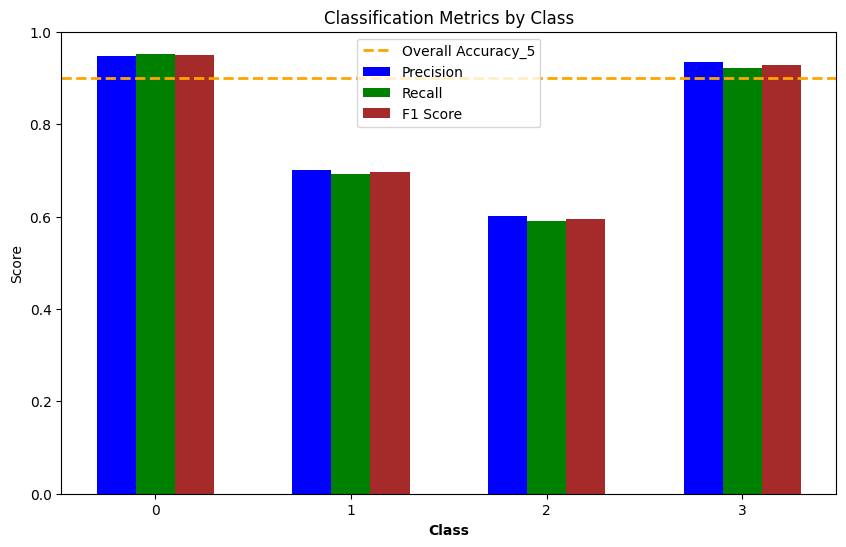

In [ ]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np

# Let's assume 'predictions' and 'y_test' are the predicted and actual labels respectively
report = classification_report(y_test, predictions_5, output_dict=True)

# Extracting the values for each class
classes = ['0', '1', '2', '3']
precision_5 = [report[cls]['precision'] for cls in classes]
recall_5 = [report[cls]['recall'] for cls in classes]
f1_score_5= [report[cls]['f1-score'] for cls in classes]
accuracy = report['accuracy']  # Overall accuracy
print (accuracy)

# Prepare the bar chart for each metric by class
bar_width = 0.2
r1 = np.arange(len(precision_5))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Plotting each metric
plt.figure(figsize=(10, 6))
plt.bar(r1, precision_5, width=bar_width, color='blue', label='Precision')
plt.bar(r2, recall_5, width=bar_width, color='green', label='Recall')
plt.bar(r3, f1_score_5, width=bar_width, color='brown', label='F1 Score')

# Adding the overall accuracy line
plt.axhline(y=accuracy, label='Overall Accuracy_5', color='orange', linestyle='--', linewidth=2)

# Adding labels and title
plt.xlabel('Class', fontweight='bold')
plt.xticks([r + bar_width for r in range(len(f1_score_5))], classes)
plt.ylabel('Score')
plt.title('Classification Metrics by Class')

# Create legend & Show graphic
plt.legend()
plt.show()

Precision for 5-dimensional data: 0.880868372524313
Recall for 5-dimensional data: 0.8831312557538245
F1-score for 5-dimensional data: 0.8818653126994245
Accuracy for 5-dimensional data:0.8831312557538245
Confusion Matrix for 5-dimensional data:
[[75074  1055  2488   735]
 [ 1213  5017  1141    14]
 [ 2947  1161  4756     0]
 [ 1154    25     0  5326]]


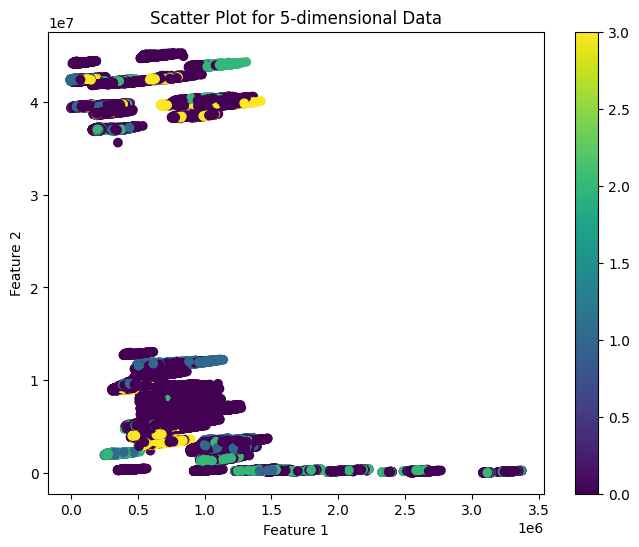

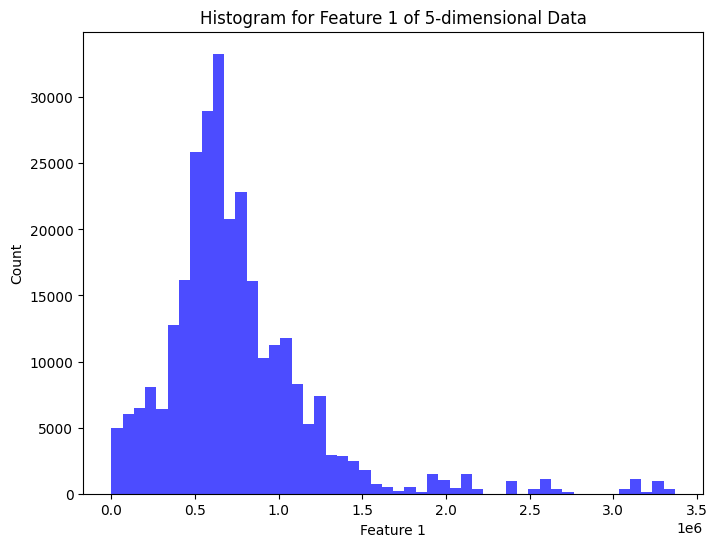

In [ ]:
print(f'Precision for 5-dimensional data: {precision_5}')
print(f'Recall for 5-dimensional data: {recall_5}')
print(f'F1-score for 5-dimensional data: {f1_5}')
print(f'Accuracy for 5-dimensional data:{accuracy_5}')
print(f'Confusion Matrix for 5-dimensional data:\n{confusion_5}')
# Scatter plot for 5-dimensional data
plt.figure(figsize=(8, 6))
plt.scatter(X_train_5[:, 0], X_train_5[:, 1], c=y_train, cmap='viridis')
plt.title('Scatter Plot for 5-dimensional Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar()
plt.show()

# Histogram for the first feature in 5-dimensional data
plt.figure(figsize=(8, 6))
plt.hist(X_train_5[:, 0], bins=50, color='blue', alpha=0.7)
plt.title('Histogram for Feature 1 of 5-dimensional Data')
plt.xlabel('Feature ')
plt.ylabel('Count')
plt.show()




Calculate reconstruction error